In this kernel I use pretrained imagenet Xception model with ResNet decoder. This was my best performing model in TGS Salt segmentation channel. I was curious about how it performs in this challenge.. You should definitely experiment with other encoder and decoder architectures. You may be able to find something better.

I use BCE Dice Loss here. There are many other losses available like Lovasz loss, focal loss etc. I hope you share the results, if you decide to experiment with them.
I used cosine annealing and Stochastic Weight Averaging to converge to a better optima.
The model's performance can be definitely be improved by using some other tricks, one obvious way is to use KFold Cross Validation. I will keep updating it as I experiment more.

I stand on the shoulder of giants. This kernel is influenced by many kernels and papers that i have read.
I will highly recommend going through other segmentation challenges especially [TGS Salt Identification Challenge](https://www.kaggle.com/c/tgs-salt-identification-challenge/kernels), [RSNA Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/kernels) and this [repo](https://github.com/titu1994). 

Some useful papers:

[Averaging Weights Leads to Wider Optima and Better Generalization][1]

[ U-Net: Convolutional Networks for Biomedical Image Segmentation][2]

[ common tricks in kaggle image segmentation problems ][3]

[Deep Residual Learning for Image Recognition][4]

[Xception: Deep Learning with Depthwise Separable Convolutions][5]


  [1]: https://arxiv.org/abs/1803.05407
  [2]: https://arxiv.org/abs/1505.04597.pdf
  [3]: https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984
  [4]: https://arxiv.org/abs/1512.03385.pdf
  [5]: https://arxiv.org/pdf/1610.02357.pdf

PS - As you guys may have noticed kaggle is not providing the data. I don't have an internation credit card so I can't access it through GCP. If we don't voice our concerns now, it may set a wrong precedent... Thanks to [CPMP](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/97005#latest-565327) for raising this issue.

TL;DR - In this kernel I train a Unet in keras for Pneumothorax Segmentation. I used mask percentage to stratify and obtain a better validation set. I use albumentations for image augmentations. I used SWA and cosine annealing for better convergance.


# Loading Libraries

In [1]:
!pip install albumentations > /dev/null
import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
from PIL import Image
%matplotlib inline

Using TensorFlow backend.


# Loading Training Set Data
As mentioned earlier, I don't have international credit card so, I am using the data from this [kernel](https://www.kaggle.com/iafoss/data-repack-and-image-statistics)

In [2]:
!mkdir masks
!unzip -q ../input/data-repack-and-image-statistics/masks.zip -d masks 
!mkdir train
!unzip -q ../input/data-repack-and-image-statistics/train.zip -d train 
!mkdir test
!unzip -q ../input/data-repack-and-image-statistics/test.zip -d test 

# Pneumothorax as percentage of mask

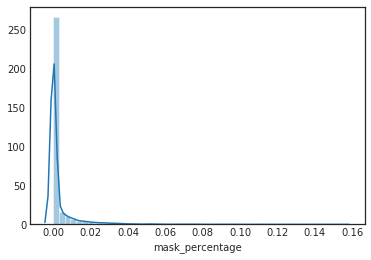

In [3]:
all_mask_fn = glob.glob('./masks/*')
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in all_mask_fn:
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum()/(256*256*255) #255 is bcz img range is 255
    
mask_df.reset_index(inplace=True)
sns.distplot(mask_df.mask_percentage)
mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage>0,'labels'] = 1

In [4]:
train_test_split?

In [5]:
all_train_fn = glob.glob('./train/*')
total_samples = len(all_train_fn)
idx = np.arange(total_samples)

train_fn,val_fn = train_test_split(all_train_fn,stratify=mask_df.labels)

print('No. of train files:', len(train_fn))
print('No. of val files:', len(val_fn))

masks_train_fn = [fn.replace('./train','./masks') for fn in train_fn]    
masks_val_fn = [fn.replace('./train','./masks') for fn in val_fn]

No. of train files: 8006
No. of val files: 2669


In [6]:
!mkdir ./keras_im_train
train_dir = './keras_im_train'
for full_fn in train_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir ./keras_mask_train
train_dir = './keras_mask_train'
for full_fn in masks_train_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir ./keras_im_val
train_dir = './keras_im_val'
for full_fn in val_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir ./keras_mask_val
train_dir = './keras_mask_val'
for full_fn in masks_val_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))

In [7]:
train_im_path,train_mask_path = './keras_im_train','./keras_mask_train'
h,w,batch_size = 256,256,64

val_im_path,val_mask_path = './keras_im_val','./keras_mask_val'

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_im_path=train_im_path,train_mask_path=train_mask_path,
                 augmentations=None, batch_size=32,img_size=256, n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = glob.glob(train_im_path+'/*')
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)

        if self.augment is None:
            return X,np.array(y)/255
        else:
            return np.stack([
                self.augment(image=x)["image"] for x in X
            ], axis=0), np.array(y)/255

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))

        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
            
            mask = np.array(Image.open(mask_path))
            
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

#             # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))

            # Store class
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
            y[y>0] = 255

        return np.uint8(X),np.uint8(y)

In [8]:
import cv2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,Cutout
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=1.2, p=0.5),
    OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.3),
    OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

# Train Set Images with Masks

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

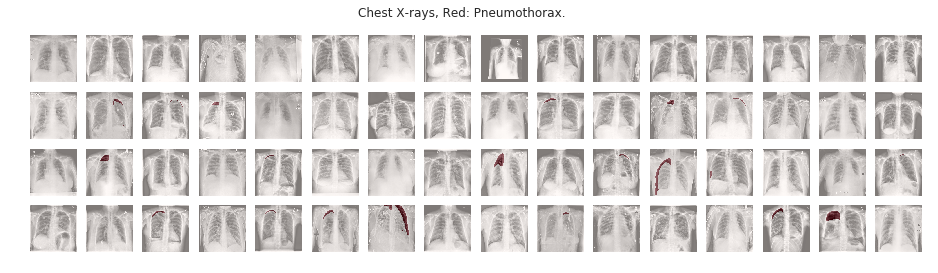

In [9]:
a = DataGenerator(batch_size=64,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

# Images after Augmentations

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

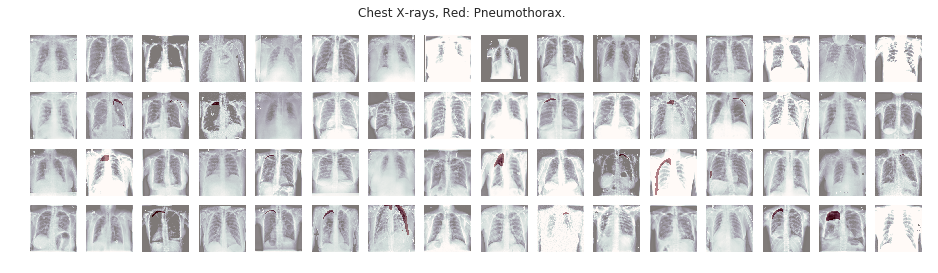

In [10]:
a = DataGenerator(batch_size=64,augmentations=AUGMENTATIONS_TRAIN,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

# Calculating IOU

In [11]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

# Defining Dice Loss

In [12]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

# Define Learning Rate Scheduler
using cosine annealing for learning rate

In [13]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

Useful Model Blocks

In [14]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

# Defining UXception Model

As mentioned above, this model uses pretrained Xception model as encoder. It uses Residual blocks in the decoder part,

In [15]:
def UXception(input_shape=(None, None, 3)):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.1)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(0.1)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(0.1/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [16]:
K.clear_session()
img_size = 128
model = UXception(input_shape=(img_size,img_size,3))

83689472/83683744 [==============================] - 1s 0us/step


# Stochastic Weight Averaging
I have found SWA to give better results. Please check out the paper for more info.

In [17]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [18]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.1], tf.float64)


In [19]:
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[my_iou_metric])

In [20]:
epochs = 40
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
batch_size = 32
swa = SWA('./keras_swa.model',35)
valid_im_path,valid_mask_path = './keras_im_val','./keras_mask_val'
# Generators
training_generator = DataGenerator(augmentations=AUGMENTATIONS_TRAIN,img_size=128)
validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=128)

history = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,                            
                            use_multiprocessing=False,
                            epochs=epochs,verbose=2,callbacks=snapshot.get_callbacks())

Stochastic weight averaging selected for last 5 epochs.
Epoch 1/40


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


 - 116s - loss: 1.1659 - my_iou_metric: 0.0000e+00 - val_loss: 14.0307 - val_my_iou_metric: 0.0000e+00

Epoch 00001: val_my_iou_metric improved from -inf to 0.00000, saving model to ./keras.model
Epoch 2/40
 - 85s - loss: 1.0249 - my_iou_metric: 0.0000e+00 - val_loss: 1.0484 - val_my_iou_metric: 0.0037

Epoch 00002: val_my_iou_metric improved from 0.00000 to 0.00375, saving model to ./keras.model
Epoch 3/40
 - 85s - loss: 0.9715 - my_iou_metric: 1.3695e-04 - val_loss: 1.2170 - val_my_iou_metric: 0.0574

Epoch 00003: val_my_iou_metric improved from 0.00375 to 0.05740, saving model to ./keras.model
Epoch 4/40
 - 84s - loss: 0.9360 - my_iou_metric: 4.8556e-04 - val_loss: 0.9227 - val_my_iou_metric: 0.6857

Epoch 00004: val_my_iou_metric improved from 0.05740 to 0.68572, saving model to ./keras.model
Epoch 5/40
 - 84s - loss: 0.9147 - my_iou_metric: 0.0215 - val_loss: 0.8531 - val_my_iou_metric: 0.6616

Epoch 00005: val_my_iou_metric did not improve from 0.68572
Epoch 6/40
 - 83s - loss: 0

Text(0.5, 1.0, 'model IOU')

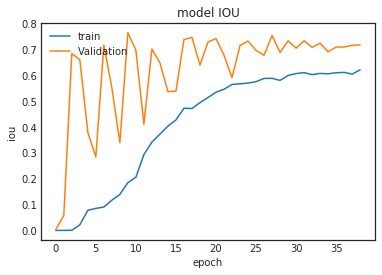

In [21]:
plt.figure()
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')


35

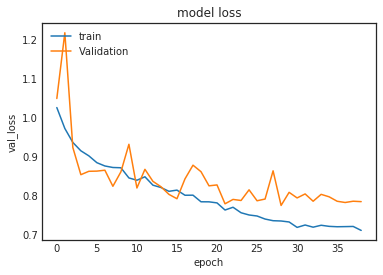

In [22]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
gc.collect()

In [23]:
# Load best model or swa model if not available
try:
    print('using swa weight model')
    model.load_weights('./keras_swa.model')
except Exception as e:
    print(e)
    model.load_weights('./keras.model')

using swa weight model


# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [24]:
def predict_result(model,validation_generator,img_size): 
    # TBD predict both orginal and reflect x
    preds_test1 = model.predict_generator(validation_generator).reshape(-1, img_size, img_size)
    return preds_test1

In [25]:
validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=128,shuffle=False)
preds_valid = predict_result(model,validation_generator,img_size)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


Text(0.5, 0.98, 'Green: Pneumothorax, Red: prediction.')

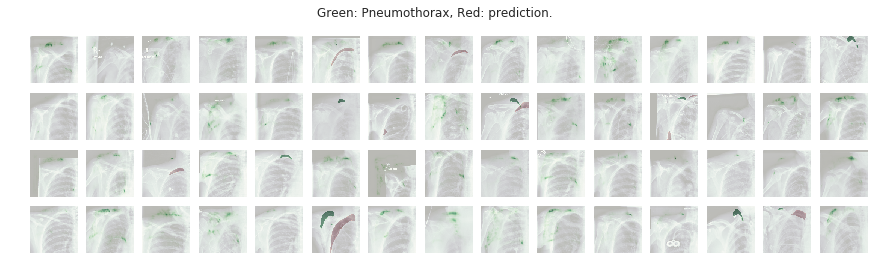

In [26]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

val_fn = glob.glob('./keras_im_val/*')
for i, valid_fn in enumerate(val_fn[:max_images]):
    img = np.array(Image.open(valid_fn))
    valid_fn = valid_fn.replace('train','mask')
    valid_fn = valid_fn.replace('keras_im_val','keras_mask_val')
    mask = np.array(Image.open(valid_fn))
    pred = preds_valid[i]
    
    ax = axs[int(i / grid_width), i % grid_width]
    
    ax.imshow(img, cmap="bone")
    ax.imshow(mask, alpha=0.5, cmap="Reds")
    ax.imshow(pred, alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green: Pneumothorax, Red: prediction.")

In [27]:
valid_fn = glob.glob('./keras_mask_val/*')
y_valid_ori = np.array([cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in valid_fn])
assert y_valid_ori.shape == preds_valid.shape

# Plot some predictions for validation set images

Text(0.5, 0.98, 'Green: Pneumothorax, Red: prediction.')

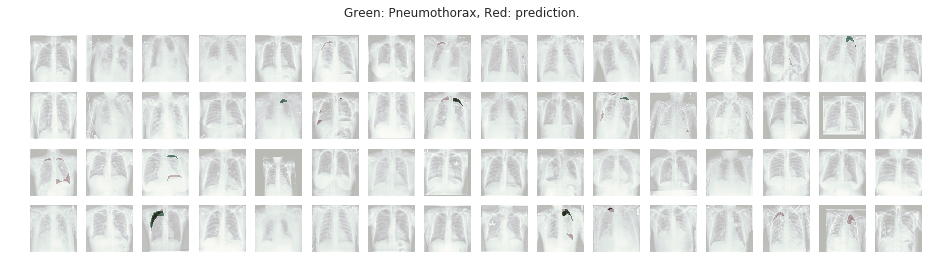

In [28]:
threshold_best = 0.5
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=128,batch_size=64,shuffle=False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green: Pneumothorax, Red: prediction.")

# Test Set Prediction

In [29]:
test_fn = glob.glob('./test/*')
x_test = [cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)
preds_test = model.predict(x_test,batch_size=32)
# del x_test; gc.collect()

(1377, 128, 128, 3)


# Some Test Set Predictions

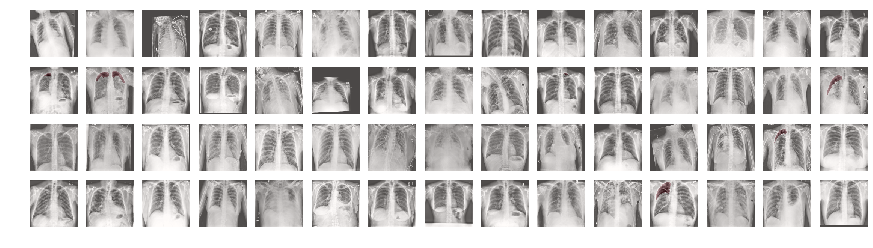

In [30]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
# for i, idx in enumerate(index_val[:max_images]):
for i, idx in enumerate(test_fn[:max_images]):
    img = x_test[i]
    pred = preds_test[i].squeeze()
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="Reds")
    ax.axis('off')

In [31]:
import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

from mask_functions import rle2mask,mask2rle

# Generate rle encodings (images are first converted to the original size)
rles = []
for p in tqdm_notebook(preds_test):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = (im[:, :] * 255. > 127).astype(np.uint8).T    
    rles.append(mask2rle(im, 1024, 1024))

In [32]:
ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.704.1517875164...,-1
1,1.2.276.0.7230010.3.1.4.8323329.5912.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.693.1517875164...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6680.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6623.151787519...,-1


In [33]:
sub_df.to_csv('submission.csv', index=False)

In [34]:
sub_df.tail(10)

,ImageId,EncodedPixels
1367,1.2.276.0.7230010.3.1.4.8323329.6848.151787520...,-1
1368,1.2.276.0.7230010.3.1.4.8323329.6770.151787520...,-1
1369,1.2.276.0.7230010.3.1.4.8323329.6608.151787519...,-1
1370,1.2.276.0.7230010.3.1.4.8323329.6871.151787520...,-1
1371,1.2.276.0.7230010.3.1.4.8323329.6010.151787519...,-1
1372,1.2.276.0.7230010.3.1.4.8323329.6726.151787519...,-1
1373,1.2.276.0.7230010.3.1.4.8323329.6528.151787519...,-1
1374,1.2.276.0.7230010.3.1.4.8323329.6645.151787519...,-1
1375,1.2.276.0.7230010.3.1.4.8323329.678.1517875164...,-1
1376,1.2.276.0.7230010.3.1.4.8323329.6362.151787519...,-1


In [35]:
!rm -r */